In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselK
from mpmath import besselk

# Cargar el archivo CSV proporcionado para los datos reales
file_path_real_data = 'Datos_DD.csv'
real_data = pd.read_csv(file_path_real_data)

real_data.head()

,t,pwf
0,0.0000,2750.00
1,0.0010,2748.95
2,0.0021,2745.62
3,0.0034,2744.63
4,0.0048,2745.49


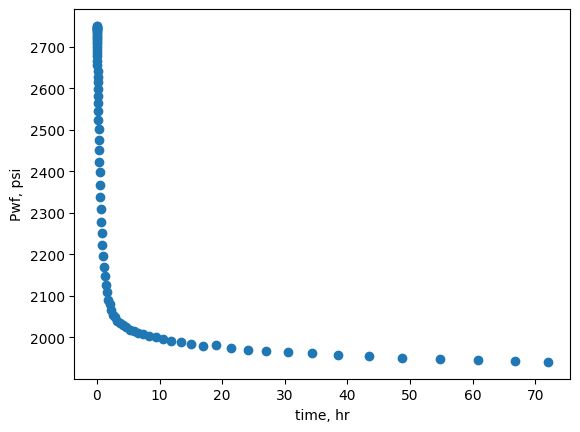

In [5]:
plt.scatter(real_data.t,real_data.pwf);
plt.xlabel('time, hr');
plt.ylabel('Pwf, psi');
plt.show();

C:\Users\chandomi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\chandomi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:1308: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\chandomi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:1309: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))


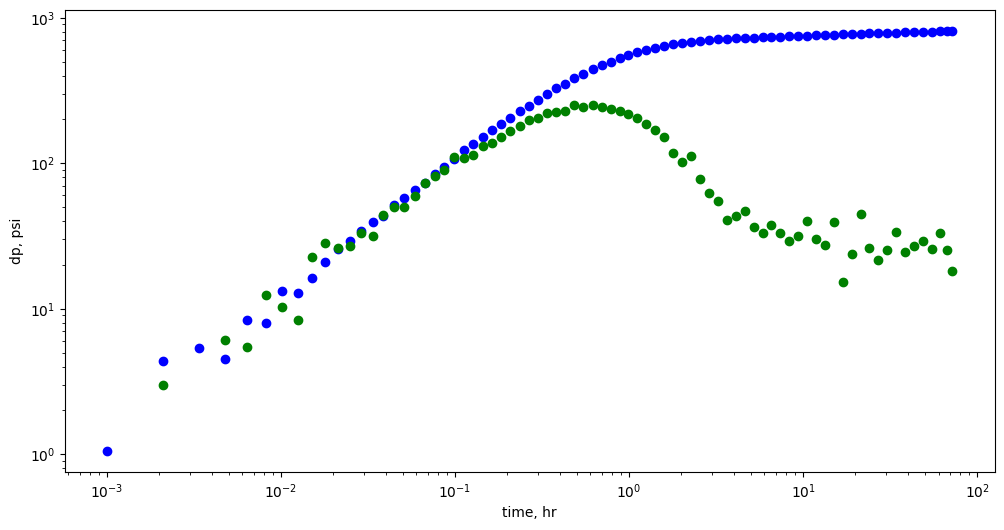

In [6]:
# Parámetros de entrada
Qo = 125  # STB/D
h = 32  # ft
phi = 0.22  # fracción
Bo = 1.125  # RB/STB
Pi = 2750  # psia
ct = 0.0000109  # 1/psia
rw = 0.25  # ft
vis = 2.122  # cp

k = 22.92
s = 5.78
C = 0.005

t_real = real_data['t']
pwf_real = real_data['pwf']

dp_real = Pi - pwf_real
dpdt_real = np.gradient(dp_real, np.log(t_real))

plt.figure(figsize=(12, 6))
plt.scatter(t_real,dp_real, color = 'blue');
plt.scatter(t_real,dpdt_real, color = 'green');
plt.xlabel('time, hr');
plt.ylabel('dp, psi');
plt.yscale('log');
plt.xscale('log');
#plt.ylim(0.0001,100000);
plt.show();


In [7]:
# Algoritmo de inversión de Stehfest 
def stehfest_inversion(tD, cD, s):
    V = np.array([-0.3333, 48.3333, -906, 5464.6667, -14376.66667, 18730, -11946.6667, 2986.6667])
    PwD = np.zeros(len(tD))

    for j in range(len(tD)):
        a = np.log(2) / tD[j]
        i = np.arange(1, len(V) + 1)
        u = i * a
        ru = np.sqrt(u)
        
        besselK_0 = besselK(0, ru)
        besselK_1 = besselK(1, ru)
        
        aux1 = besselK_0 + s * ru * besselK_1
        aux2 = ru * besselK_1 + cD * u * (besselK_0 + s * ru * besselK_1)

        # Evitar divisiones por cero o números indefinidos
        aux2 = np.where(aux2 == 0, 1e-10, aux2)
        
        PwDL = np.divide(aux1, aux2) / u
        PwD[j] = a * np.sum(V * PwDL)

    return PwD

In [8]:
# Cálculo de tD y cD usando los tiempos reales del archivo
tD_real = (0.0002637 * k * t_real) / (phi * vis * ct * rw ** 2)
cD = (0.8936 * C) / (h * phi * ct * rw ** 2)

# Presión simulada 
PwD = stehfest_inversion(tD_real, cD, s)

# Cálculo de la presión y dp/dt
dp_cal = (PwD * 141.2 * Bo * vis * Qo) / (h * k)
pwf_cal = Pi - dp_cal
dpdt_cal = np.gradient(dp_cal, np.log(t_real))

C:\Users\chandomi\AppData\Local\Temp\ipykernel_30820\4049813834.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  a = np.log(2) / tD[j]
C:\Users\chandomi\AppData\Local\Temp\ipykernel_30820\4049813834.py:15: RuntimeWarning: invalid value encountered in multiply
  aux1 = besselK_0 + s * ru * besselK_1
C:\Users\chandomi\AppData\Local\Temp\ipykernel_30820\4049813834.py:16: RuntimeWarning: invalid value encountered in multiply
  aux2 = ru * besselK_1 + cD * u * (besselK_0 + s * ru * besselK_1)


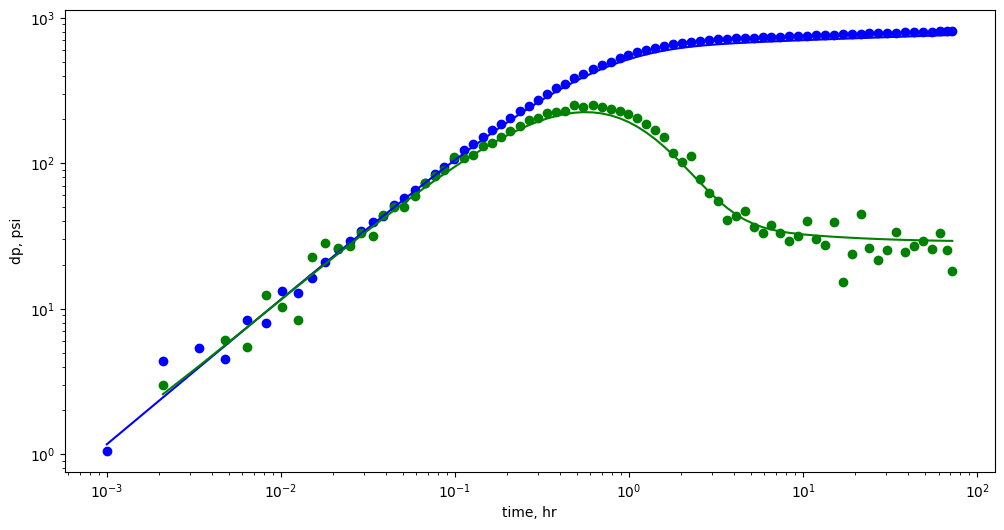

In [9]:
plt.figure(figsize=(12, 6))
plt.scatter(t_real,dp_real, color = 'blue');
plt.scatter(t_real,dpdt_real, color = 'green');
plt.plot(t_real,dp_cal, color = 'blue');
plt.plot(t_real,dpdt_cal, color = 'green');
plt.xlabel('time, hr');
plt.ylabel('dp, psi');
plt.yscale('log');
plt.xscale('log');
#plt.ylim(0.0001,100000);
plt.show();
